# Lyft Bay Wheels Data Exploration
## by Claire Li

This project uses trip data from Lyft's Bay Wheels, a bikeshare service based in San Francisco, CA. The goal of this project is to glean insights from the dataset using data visualizations. 

## Table of Contents
<ul>
<li><a href="#wrangling">Preliminary Wrangling</a></li>
<li><a href="#univariate">Univariate Exploration</a></li>
<li><a href="#bivariate">Bivariate Exploration</a></li>
<li><a href="#multivariate">Multivariate Exploration</a></li>
<li><a href="#conclusion">Conclusions</a></li>
</ul>


<a id='wrangling'></a>
## Preliminary Wrangling

In [23]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium 
from geopy import distance
import datetime as dt

%matplotlib inline


In [3]:
baywheels = pd.read_csv('baywheels-tripdata.csv')
baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_equity
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,False
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,False
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,False
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,False
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,False


In [4]:
print(baywheels.shape, '\n')

baywheels.info()

(138251, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138251 entries, 0 to 138250
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             138251 non-null  object 
 1   rideable_type       138251 non-null  object 
 2   started_at          138251 non-null  object 
 3   ended_at            138251 non-null  object 
 4   start_station_name  87315 non-null   object 
 5   start_station_id    87315 non-null   float64
 6   end_station_name    84779 non-null   object 
 7   end_station_id      84779 non-null   float64
 8   start_lat           138251 non-null  float64
 9   start_lng           138251 non-null  float64
 10  end_lat             138027 non-null  float64
 11  end_lng             138027 non-null  float64
 12  member_casual       138251 non-null  object 
 13  is_equity           138251 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 13.8+ MB


In [5]:
#Change started_at and ended_at columns to correct data types 
baywheels['started_at'] = pd.to_datetime(baywheels['started_at'])
baywheels['ended_at'] = pd.to_datetime(baywheels['ended_at'])

#Check time range of the dataset 
baywheels.started_at.min(), baywheels.started_at.max()

(Timestamp('2020-05-01 00:00:14'), Timestamp('2020-05-31 23:59:57'))

In [6]:
#Unsure what is_equity column refers to, since there is no mention of it in the notes; will drop from analysis 
baywheels.drop(columns = ['is_equity'], inplace = True)

In [7]:
#Check member status 
print(baywheels.member_casual.unique())
print("Number of non-subscribers/non-members: ", baywheels.member_casual.isin(["casual"]).sum())
print("Number of subscribers/members: ", baywheels.member_casual.isin(["member"]).sum())

['casual' 'member']
Number of non-subscribers/non-members:  84519
Number of subscribers/members:  53732


It seems that there are some missing values for start and end station names. 

In [8]:
missing_start = baywheels[baywheels['start_station_name'].isnull() & ~baywheels['start_lat'].isnull()]

#List of starting coordinates without a corresponding name
start_coords = list(zip(missing_start.start_lat, missing_start.start_lng))

#Get rid of duplicates 
start_coords = list(dict.fromkeys(start_coords))

In [9]:
#Are any of the start coords with missing names given a name elsewhere? (No)
temp = baywheels.copy()
temp['start_coords'] = zip(temp.start_lat, temp.start_lng)

temp[temp['start_coords'].isin(start_coords) & ~temp['start_station_name'].isnull()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_coords


### What is the structure of your dataset?

>There are 138,251 trips in the dataset, which represents trips taken in the month of May 2020. There are some missing values for information about start and end locations. I was unsure what the `is_equity` column refers to, as it is not discussed in the dataset notes, so that column was dropped from the analysis.  


### What is/are the main feature(s) of interest in your dataset?

> I am interested in investigating the following features: 
* **Peak hours**: What time of day, week, and month had the highest amount of activity? 
* **Ride details**: What is the average duration and distance of a bikeshare ride? Where are the start and end stations located? 
* **Rider information**: Where are most members located? How about non-members? How do they differ in ride distance or duration? 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The month of May 2020 was the 3rd month of quarantine/shelter-in-place orders due to the coronavirus pandemic; as a result, use of the Bay Wheels service might have been less than usual. Still, I would expect that areas closer to the center of the city would be more frequently used stops. Since San Francisco is a relatively small city, I'd expect the average distance of a ride to be no more than a mile. As for the distribution of members vs. non-members, I do not think there will be a significant trend in areas they are located. 
* `started_at` and `ended_at` columns will be used for analyzing peak activity times, as well as average duration of a ride 
* Start/end coordinates and station names (when given) will be used for analysis of ride distances and frequently visited hubs. 
* `member_casual` will be used to between members and non-members; along with the associated geographical information, I will attempt to see if there are certain areas that attract more members. 

<a id='univariate'></a>
## Univariate Exploration

### Peak Hours
I will first start with an exploration of time data, to try to identify peak usage times within the day and the month. For this section, I will use the start times for each ride. 

In [10]:
#Create columns for date of month, day of week, and time of day
baywheels['start_day'] = baywheels['started_at'].dt.day

baywheels['day_of_week'] = baywheels['started_at'].dt.weekday
baywheels['day_of_week'].replace({0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}, inplace = True)
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_type = pd.api.types.CategoricalDtype(ordered = True, categories = days)
baywheels['day_of_week'] = baywheels['day_of_week'].astype(day_type)

baywheels['time_of_day'] = baywheels['started_at'].dt.hour

baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_day,day_of_week,time_of_day
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,18,Mon,22
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,19,Tues,16
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,18,Mon,20
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,19,Tues,14
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,10,Sun,17


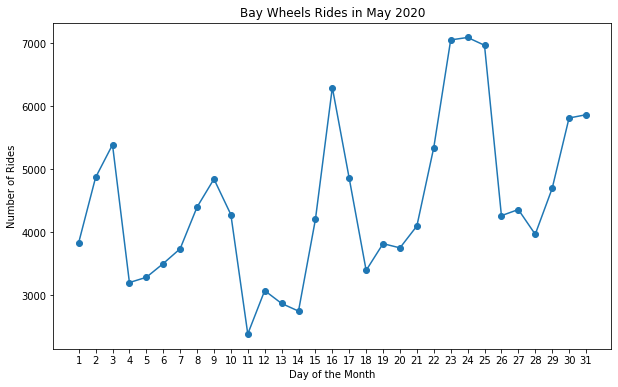

In [11]:
#Scatterplot for time of month 
temp = baywheels.copy().groupby('start_day').count().reset_index()
plt.figure(figsize = [10, 6]);
plt.plot(temp["start_day"], temp["ride_id"], marker = 'o'); 
dates = np.arange(1, 32, 1)
plt.xticks(dates);
plt.xlabel("Day of the Month");
plt.ylabel("Number of Rides");
plt.title("Bay Wheels Rides in May 2020");

We can see 5 distinct peaks in this scatter plot (including the spike for the last few days). My guess would be that they correspond to weekends, with the largest peak being Memorial Day weekend (May 22 - 25). Let's investigate this by graphing number of trips by days of the week. 

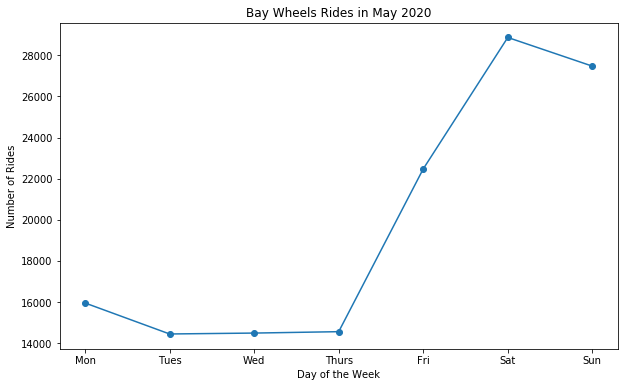

In [12]:
#Scatterplot for day of week 
temp = baywheels.copy().groupby('day_of_week').count().reset_index()
plt.figure(figsize = [10, 6])
plt.plot(temp["day_of_week"], temp["ride_id"], marker = 'o'); 
plt.xlabel("Day of the Week");
plt.ylabel("Number of Rides");
plt.title("Bay Wheels Rides in May 2020");

Indeed, there are significantly more rides occurring on Fri-Sun than during the rest of the week. I will further examine what time of day has the most activity. 

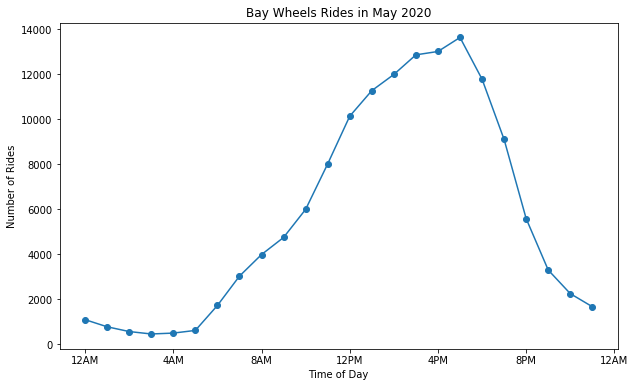

In [13]:
#Scatterplot for time of day 
temp = baywheels.copy().groupby('time_of_day').count().reset_index()
plt.figure(figsize = [10, 6])
plt.plot(temp["time_of_day"], temp["ride_id"], marker = 'o'); 
plt.xlabel("Time of Day");
plt.ylabel("Number of Rides");
plt.xticks([0,4,8, 12, 16, 20, 24],["12AM", "4AM","8AM","12PM","4PM", "8PM", "12AM"]);
plt.title("Bay Wheels Rides in May 2020");

As one might expect, there is a peak in activity at 5PM, a time when many people are getting off of work for the day. However, it is a little surprising that there is not a similar peak in the morning, when people are typically headed to work for the day. This trend may perhaps be attributed to shelter-in-place orders due to the coronavirus outbreak: since more people are working from home, there are less people needing to commute to work. The 5PM spike may be instead due to bike usage for leisure rather than commute. This is mere conjecture, however, and cannot be proven without further evidence. 

### Ride Details
Next, I will explore some features related to the rides taken.  

In [14]:
#Create column for ride duration 
baywheels['duration'] = baywheels['ended_at'] - baywheels['started_at']
baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_day,day_of_week,time_of_day,duration
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,18,Mon,22,00:12:14
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,19,Tues,16,00:32:21
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,18,Mon,20,00:06:11
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,19,Tues,14,00:09:08
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,10,Sun,17,00:43:35


In [15]:
#Examine distribution of durations
baywheels.duration.describe()

count                    138251
mean     0 days 00:28:59.217242
std      0 days 04:35:19.518120
min           -1 days +23:59:13
25%             0 days 00:07:28
50%             0 days 00:14:10
75%             0 days 00:27:07
max            23 days 20:30:15
Name: duration, dtype: object

In [16]:
#Examine the rides that have a negative duration
print(baywheels[baywheels['ended_at'] < baywheels['started_at']].duration.describe())

count                         211
mean     -1 days +23:59:47.568720
std        0 days 00:00:04.776805
min             -1 days +23:59:13
25%             -1 days +23:59:46
50%             -1 days +23:59:48
75%             -1 days +23:59:50
max             -1 days +23:59:59
Name: duration, dtype: object


It seems that there are 211 rides that have a recorded ending time before their starting time. Given that the two recorded times for these entries are, for the most part, merely seconds apart, these are most likely accidental records and thus will be dropped from the data set. 

In [17]:
baywheels = baywheels[baywheels['ended_at'] > baywheels['started_at']]
print(baywheels[baywheels['ended_at'] < baywheels['started_at']].shape)
baywheels.duration.describe()

(0, 17)


count                    138001
mean     0 days 00:29:02.386982
std      0 days 04:35:34.306659
min             0 days 00:00:01
25%             0 days 00:07:30
50%             0 days 00:14:12
75%             0 days 00:27:09
max            23 days 20:30:15
Name: duration, dtype: object

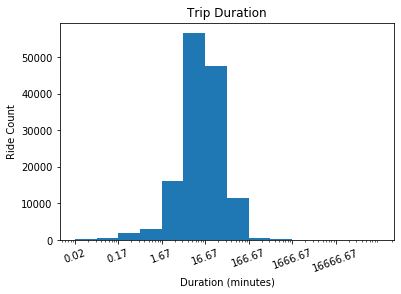

In [18]:
bins = np.logspace(0, 7, num = 15)
plt.hist(baywheels['duration'].astype('timedelta64[s]'), bins = bins);
plt.xscale('log'); 

ticks = 10 ** np.arange(0, 7, 1)
labels = ticks/60
plt.xticks(ticks, np.round(labels, 2), rotation = 20);
plt.xlabel("Duration (minutes)");
plt.ylabel("Ride Count"); 
plt.title("Trip Duration");

This appears to show that most trips are around 15-30 minutes long. The mean is slightly higher, at around 30 minutes, but this could be skewed from several trips that lasted over several days. 

Next, we use the Python library Folium to create an interactive map of the start stations.  

In [19]:
import folium

In [20]:
sf_lat = 37.7749
sf_long = -122.4194

#for efficiency, use only the start stations with labeled names
start_stations = baywheels[~baywheels.start_station_name.isnull()]
start_stations.drop_duplicates(subset = 'start_station_name', inplace = True)

# create map of SF using latitude and longitude values
map_sf= folium.Map(location=[sf_lat, sf_long], zoom_start=10)

# add markers to map
for lat, lng, name in zip(start_stations['start_lat'], start_stations['start_lng'], start_stations['start_station_name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I didn't realize this before, but the rides are not just located in the city of San Francisco; there are 3 clusters centered at San Francisco, San Jose, and Oakland/Berkeley. I will add another column to the dataset to label which cluster each ride starts and ends in. 

In [630]:
sf_coords = (37.733795, -122.4194)
sj_coords = (37.3382, -121.8863)
oak_coords = (37.8044, -122.2712)
berk_coords = (37.8715, -122.2730)

#function to identify the start/end city of each ride, based on the approx coordinates of the three clusters identified 
def city_id(lat, long):
    try: 
        if lat < 37.6: 
            return "SJ" 
        if long < -122.3: 
            return "SF"
        else: 
            return "Oakland/Berkeley"
    except: 
        return "None"

In [631]:
baywheels['start_city'] = baywheels.apply(lambda row: city_id(row['start_lat'], row['start_lng']), axis = 1)
baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_day,day_of_week,time_of_day,duration,start_city
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,18,Mon,22,00:12:14,SJ
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,19,Tues,16,00:32:21,SF
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,18,Mon,20,00:06:11,SF
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,19,Tues,14,00:09:08,SF
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,10,Sun,17,00:43:35,SF


In [632]:
baywheels.start_city.value_counts()

SF                  108331
SJ                   18016
Oakland/Berkeley     11654
Name: start_city, dtype: int64

In [633]:
baywheels['end_city'] = baywheels.apply(lambda row: city_id(row['end_lat'], row['end_lng']), axis = 1)
baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_day,day_of_week,time_of_day,duration,start_city,end_city
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,18,Mon,22,00:12:14,SJ,SJ
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,19,Tues,16,00:32:21,SF,SF
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,18,Mon,20,00:06:11,SF,SF
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,19,Tues,14,00:09:08,SF,SF
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,10,Sun,17,00:43:35,SF,SF


In [634]:
baywheels.end_city.value_counts()

SF                  108205
SJ                   17987
Oakland/Berkeley     11809
Name: end_city, dtype: int64

These cities will be used later in bivariate and multivariate analysis. For now, I'll also calculate the distance of each ride, using the GeoPy library. 

In [166]:
from geopy import distance

In [176]:
#function to calculate distance 
def ride_distance(start, end): 
    try: 
        dist = distance.distance(start, end).miles
    except: #some entries don't have coords, causing an error 
        dist = np.NaN  
    return dist

In [270]:
baywheels['distance'] = baywheels.apply(lambda row: ride_distance((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis = 1)
baywheels.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_day,day_of_week,time_of_day,duration,distance,start_city,end_city
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,37.3443,-121.9217,casual,18,Mon,22,0 days 00:12:14.000000000,0.005506,SJ,SJ
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,37.7154,-122.4854,casual,19,Tues,16,0 days 00:32:21.000000000,0.981568,SF,SF
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,37.7906,-122.4325,casual,18,Mon,20,0 days 00:06:11.000000000,0.831286,SF,SF
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,37.7681,-122.4266,casual,19,Tues,14,0 days 00:09:08.000000000,1.018413,SF,SF
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,37.7780,-122.4144,casual,10,Sun,17,0 days 00:43:35.000000000,1.668784,SF,SF


In [178]:
baywheels.distance.describe()

count    137777.000000
mean          1.251134
std           1.102128
min           0.000000
25%           0.426284
50%           1.005117
75%           1.820915
max          30.774068
Name: distance, dtype: float64

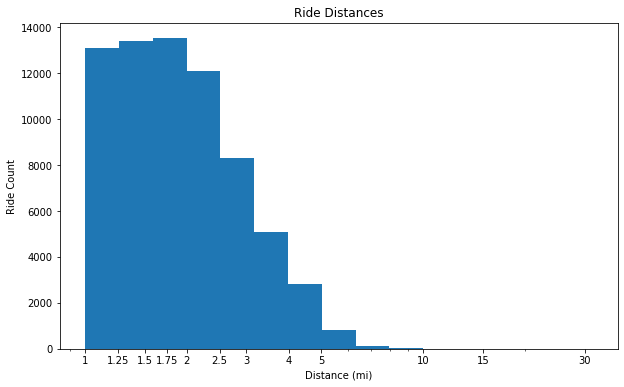

In [208]:
bins = 10 ** np.arange(0, 1.5 + 0.1, 0.1)
plt.figure(figsize = [10, 6]);
plt.hist(baywheels.distance, bins = bins);
plt.xscale('log');
ticks = [1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5, 10, 15, 30]
plt.xticks(ticks, ticks);

plt.xlabel("Distance (mi)"); 
plt.ylabel("Ride Count"); 
plt.title("Ride Distances"); 

We can see that most rides fall somewhere under 3 miles, with quite a few outliers (with the longest ride being over 30 miles). To gain more insight into the "typical" ride, I will zoom in to focus on rides that are under 3 miles. 

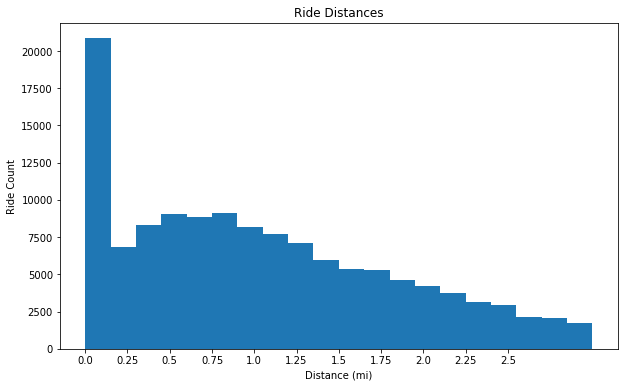

In [595]:
plt.figure(figsize = [10, 6]);
plt.hist(baywheels[baywheels.distance < 3].distance, bins = 20);

ticks = np.arange(0, 2.75, 0.25); 
plt.xticks(ticks, ticks);

plt.xlabel("Distance (mi)"); 
plt.ylabel("Ride Count"); 
plt.title("Ride Distances"); 

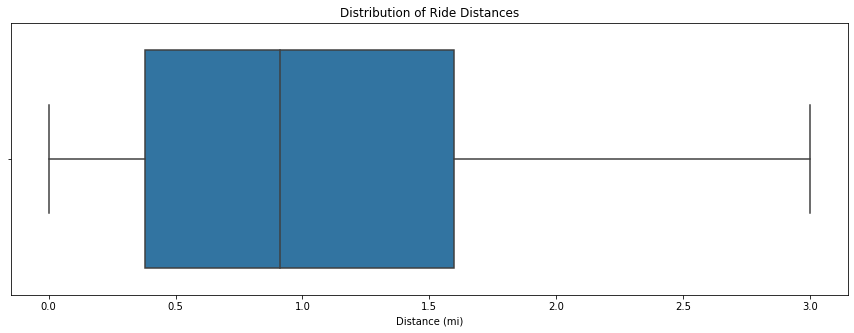

In [593]:
plt.figure(figsize = [15, 5]);
sb.boxplot(baywheels[baywheels.distance < 3].distance);
plt.title("Distribution of Ride Distances");
plt.xlabel("Distance (mi)"); 

In [594]:
baywheels[baywheels.distance < 3].distance.describe()

count    127246.000000
mean          1.033192
std           0.795626
min           0.000000
25%           0.377560
50%           0.911747
75%           1.596140
max           2.999937
Name: distance, dtype: float64

The histogram tells us that most rides are actually shorter than 0.25 mi. This, however, could also include round-trip rides that start and end at the same location. From the boxplot, we can see that the median distance for rides under 3 mi is around **0.90 mi**, the 25th percentile is **0.38 mi** and the 75th percentile is around **1.60 mi**. Interesting!

### Rider Information 

Finally, I will take a quick look at the distribution of members vs. non-members. 

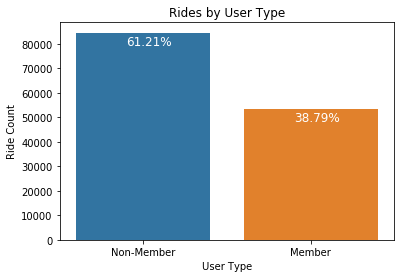

In [492]:
plt.figure(figsize = [6, 4] )
ax = sb.countplot(data = baywheels, x = 'member_casual'); 
plt.title("Rides by User Type"); 
plt.xlabel("User Type"); 
plt.ylabel("Ride Count"); 
ax.set_xticklabels(['Non-Member', 'Member'])

# create a list to collect the plt.patches data
totals = []

for i in ax.patches:
    totals.append(i.get_height())

# set individual bar labels using above list
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x() + 0.3, i.get_height() - 5000, \
            str(round((i.get_height()/total)*100, 2))+'%', color = 'w', fontsize=12)

It seems that during May 2020, the majority of the riders were actually non-members. The distribution of members vs. non-members will be investigated more in later sections of this project. 

In [271]:
#save as csv as checkpoint  
baywheels.to_csv('baywheels2.csv',encoding='utf-8',index=False)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

>I noticed the following: 
* **Peak hours**: There were definite increases in rides over the weekend, with Memorial Day weekend seeing the highest amount of activity. Additionally, there tends to be more activity around 5PM each day. 
* **Ride details**: The average ride duration is around 15-30 minutes long. There are actually 3 separate geographical clusters: San Francisco, East Bay (Oakland/Berkeley), and South Bay (San Jose), with San Francisco having the highest number of rides. I identified the start and end cluster of each ride and will perform further analysis in later sections. Also, the average ride distance is around 1.25 mi, though this is skewed by a few outliers. Removing the outliers tells us that the typical ride is somewhere between 0.5 and 1.0 miles.   
* **Rider information**: Most riders are not members.



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Since ride duration varied so greatly (e.g., some rides lasting several days, some rides with a negative value for duration), a lot of cleaning had to be done. I dropped all the records that had a recorded end time before its recorded start time, and then performed a log-transform on the data. This allowed me to see that most rides lasted around 15 minutes. Similarly, for the ride distance, I also performed a log-transform when plotted with the entire dataset, and then created another plot with just the shorter distances that were more common. 

<a id='bivariate'></a>
## Bivariate Exploration

### Peak Hours

In [58]:
#load csv 
baywheels = pd.read_csv('baywheels2.csv')

#Fix data types
baywheels['duration'] = pd.to_timedelta(baywheels['duration'])
baywheels['started_at'] = pd.to_datetime(baywheels['started_at'])
baywheels['ended_at'] = pd.to_datetime(baywheels['ended_at'])
baywheels['day_of_week'] = baywheels['day_of_week'].astype(day_type)

baywheels['duration_min'] = baywheels['duration'].astype('timedelta64[m]')

baywheels.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,start_day,day_of_week,time_of_day,duration,distance,start_city,end_city,duration_min
0,BA4B4D93677877E8,electric_bike,2020-05-18 22:16:06,2020-05-18 22:28:20,NaN,NaN,NaN,NaN,37.3443,-121.9218,...,-121.9217,casual,18,Mon,22,00:12:14,0.005506,SJ,SJ,12.0
1,92634E825C7303CC,electric_bike,2020-05-19 16:57:35,2020-05-19 17:29:56,NaN,NaN,NaN,NaN,37.7286,-122.4921,...,-122.4854,casual,19,Tues,16,00:32:21,0.981568,SF,SF,32.0
2,1FCDD14C62521CC1,electric_bike,2020-05-18 20:08:14,2020-05-18 20:14:25,NaN,NaN,Webster St at Clay St,492.0,37.7919,-122.4174,...,-122.4325,casual,18,Mon,20,00:06:11,0.831286,SF,SF,6.0
3,3A5CEC684CA9FA18,electric_bike,2020-05-19 14:05:08,2020-05-19 14:14:16,NaN,NaN,NaN,NaN,37.7557,-122.4165,...,-122.4266,casual,19,Tues,14,00:09:08,1.018413,SF,SF,9.0
4,1FF95A9C2D1ED7F8,electric_bike,2020-05-10 17:45:54,2020-05-10 18:29:29,Pier 1/2 at The Embarcadero,12.0,NaN,NaN,37.7964,-122.3946,...,-122.4144,casual,10,Sun,17,00:43:35,1.668784,SF,SF,43.0
5,E0937CAFF4D56EC0,electric_bike,2020-05-11 08:45:24,2020-05-11 08:52:55,NaN,NaN,NaN,NaN,37.7856,-122.4134,...,-122.4156,casual,11,Mon,8,00:07:31,0.288416,SF,SF,7.0
6,82AB84FFF9D4A01E,electric_bike,2020-05-11 00:12:32,2020-05-11 00:22:25,NaN,NaN,NaN,NaN,37.7783,-122.4143,...,-122.4142,casual,11,Mon,0,00:09:53,0.014840,SF,SF,9.0
7,87AB71D10C30CBBA,electric_bike,2020-05-10 23:58:34,2020-05-11 00:00:44,NaN,NaN,NaN,NaN,37.7285,-122.3847,...,-122.3866,casual,10,Sun,23,00:02:10,0.121180,SF,SF,2.0
8,574118AD595764A4,electric_bike,2020-05-11 15:28:48,2020-05-11 15:55:37,Willow St at Blewett Ave,473.0,Palm St at Willow St,300.0,37.3090,-121.9000,...,-121.8849,casual,11,Mon,15,00:26:49,1.005762,SJ,SJ,26.0
9,6B81C2AF414B8AD3,electric_bike,2020-05-11 23:01:05,2020-05-11 23:44:36,NaN,NaN,NaN,NaN,37.7786,-122.3911,...,-122.4225,casual,11,Mon,23,00:43:31,2.128203,SF,SF,43.0


Let's examine what time of day is most popular.

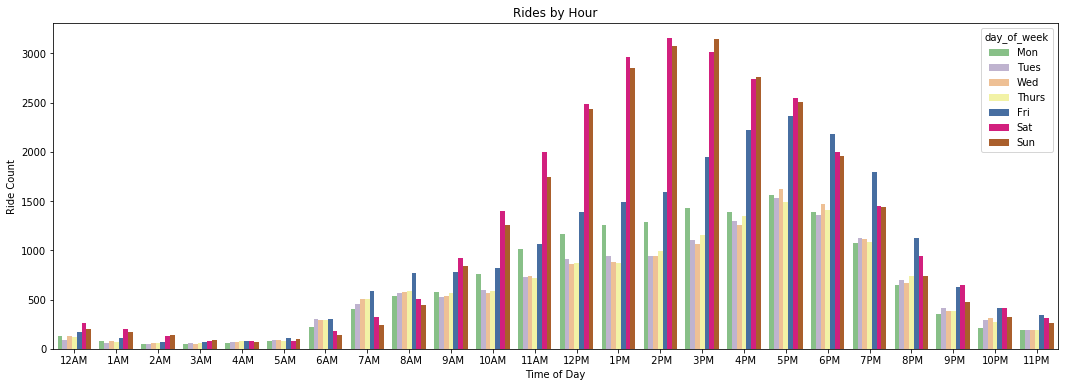

In [25]:
plt.figure(figsize = [18, 6])
sb.countplot(data = baywheels, x = 'time_of_day', hue = 'day_of_week', palette = 'Accent'); 

plt.xlabel("Time of Day"); 
ticks = np.arange(0, 24, 1)
hours = [(dt.time(i).strftime('%l%p')) for i in range(24)]
plt.xticks(ticks, hours);
plt.ylabel("Ride Count");
plt.title("Rides by Hour");

From this, we can see that there is generally the highest amount of activity between noon and 6PM every day, with significantly more rides on the weekends (Fri, Sat, and Sun). During the week, number of rides generally increases from 12PM to 5PM, and then tapers down. During the weekend, the peak occurs around 2-3PM. For the off-hours (e.g., 12AM-5AM, after 8PM), the number of rides is approximately the same across all days of the week. 

### Ride Details

I'll start by plotting distance vs. duration.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


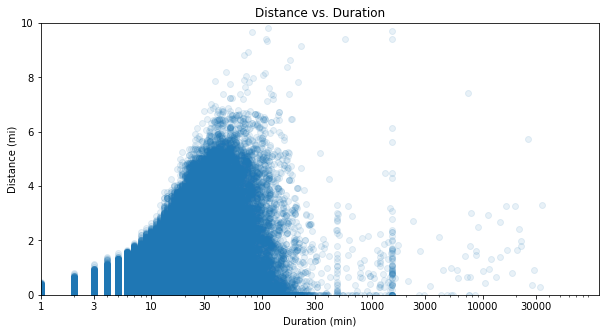

In [26]:
dist_dur = baywheels[~baywheels.distance.isnull()]
dist_dur['duration'] = dist_dur['duration'].astype('timedelta64[m]')

plt.figure(figsize = [10, 5])
plt.scatter(data = dist_dur, x = 'duration', y = 'distance', alpha = 0.1);

plt.xscale('log'); 
ticks = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.xticks(ticks, ticks);
plt.ylim([0, 10]);
plt.xlabel("Duration (min)");
plt.ylabel("Distance (mi)");
plt.title("Distance vs. Duration");


From this, we can again see that most rides are under 5 miles and under 30 minutes long. We generally see that rides that last longer travel longer distances. However, it's interesting that the longer rides are not always associated with longer distances. This could perhaps be due to people who rent a bike and do not use it constantly through their entire rental period, or perhaps people who make a round trip and end at a stop near where they started. 

Next, I hypothesize that longer rides, both in terms of distance and duration, occur on the weekends. I will use violin plots to investigate this more closely. 

Text(0.5, 1.0, 'Distance vs. Day of Week')

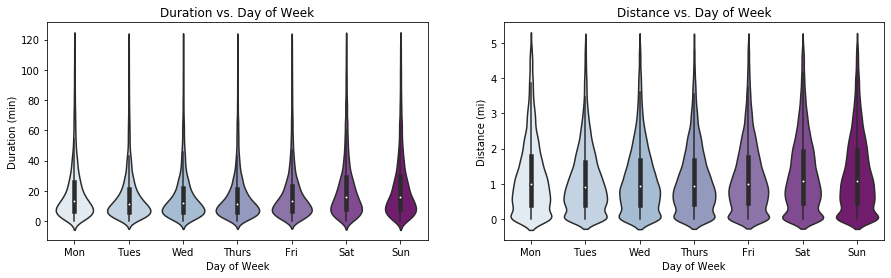

In [28]:
figure = plt.figure(figsize = [15, 4])

#Remove outliers: keep only rides under 2 hours and 5 miles 
dist_dur = dist_dur[(dist_dur['duration'] < 120) & (dist_dur['distance'] < 5)]

plt.subplot(1, 2, 1);
sb.violinplot(data = dist_dur, x = 'day_of_week', y = 'duration', palette = 'BuPu');
plt.xlabel("Day of Week"); 
plt.ylabel("Duration (min)");
plt.title("Duration vs. Day of Week")

plt.subplot(1, 2, 2); 
sb.violinplot(data = dist_dur, x = 'day_of_week', y = 'distance', palette = 'BuPu');
plt.xlabel("Day of Week"); 
plt.ylabel("Distance (mi)");
plt.title("Distance vs. Day of Week")


Surprisingly, there doesn't seem to be that much of a difference in duration or distance by day of the week. It looks like there might be slightly longer rides in terms of duration on Sat and Sun, but the difference does not seem to be that noticeable. This may again be attributed to the effects of the coronavirus quarantine orders for shelter in place: since people no longer have to go to work, people are no longer using the bikes to commute to their offices, so perhaps most of the rides are now for leisure and are more evenly distributed (in terms of duration and distance) throughout the week. 

Finally, I'd also like to examine average ride duration and distance for each city. 

In [60]:
by_city = baywheels.copy()
by_city['duration'] = pd.to_timedelta(by_city['duration'])
by_city['duration'] = by_city['duration'].astype('timedelta64[m]')
by_city = by_city.groupby('start_city')[['distance', 'duration']].mean()

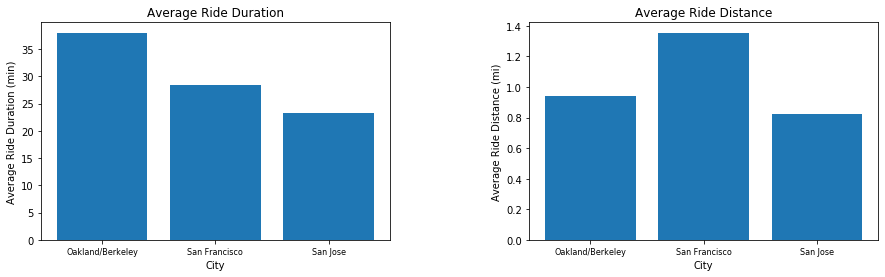

In [30]:
figure = plt.figure(figsize = [15, 4])

plt.subplot(1, 2, 1);
plt.bar(x = by_city.index, height = by_city.duration);
plt.title("Average Ride Duration");
plt.xticks(by_city.index, ['Oakland/Berkeley', 'San Francisco', 'San Jose'], fontsize = 8)
plt.xlabel("City");
plt.ylabel("Average Ride Duration (min)");

plt.subplot(1, 2, 2);
plt.bar(x = by_city.index, height = by_city.distance);
plt.title("Average Ride Distance");
plt.xticks(by_city.index, ['Oakland/Berkeley', 'San Francisco', 'San Jose'], fontsize = 8)
plt.xlabel("City");
plt.ylabel("Average Ride Distance (mi)");

plt.subplots_adjust(wspace = 0.4);

Here, we see that rides that start in Oakland/Berkeley have a higher average time duration, while rides that start in SF have a higher average distance. 

### Rider Information 

First, let's look at where the members are located geographically. 

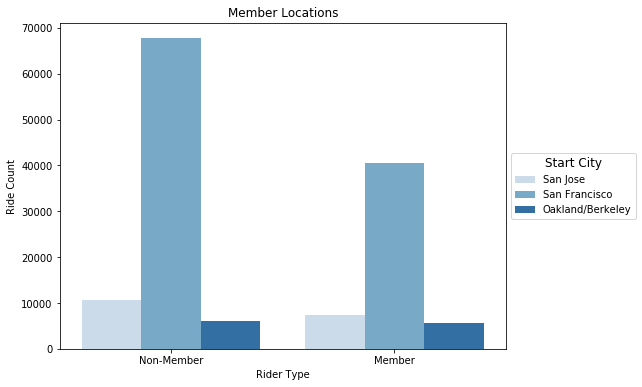

In [31]:
plt.figure(figsize = [8,6]); 
ax = sb.countplot(data = baywheels, x = 'member_casual', hue = 'start_city', palette = 'Blues');
ax.set_xticklabels(['Non-Member', 'Member']);
ax.set_xlabel("Rider Type");
ax.set_ylabel("Ride Count");
ax.set_title("Member Locations");
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= "Start City", title_fontsize = 12, labels = ['San Jose', 'San Francisco', 'Oakland/Berkeley']);

Most riders, both members and non-members, start from San Francisco. There is a large gap betwen non-members and members in San Francisco, but it seems to be about an even split between non-members and members in San Jose and Oakland/Berkeley. 

Next, I'll look at duration and distance of rides by members vs. non-members. 

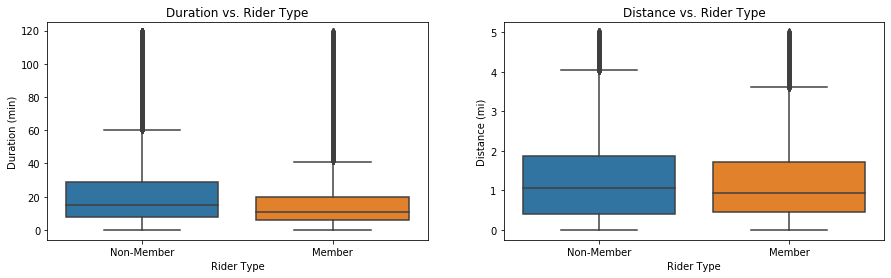

In [32]:
figure = plt.figure(figsize = [15, 4])

#Remove outliers: keep only rides under 2 hours and 5 miles 
dist_dur = dist_dur[(dist_dur['duration'] < 120) & (dist_dur['distance'] < 5)]

plt.subplot(1, 2, 1);
ax1 = sb.boxplot(data = dist_dur, x = 'member_casual', y = 'duration');
plt.xlabel("Rider Type"); 
plt.ylabel("Duration (min)");
plt.title("Duration vs. Rider Type");
ax1.set_xticklabels(['Non-Member', 'Member']);

plt.subplot(1, 2, 2); 
ax2 = sb.boxplot(data = dist_dur, x = 'member_casual', y = 'distance');
plt.xlabel("Rider Type"); 
plt.ylabel("Distance (mi)");
plt.title("Distance vs. Rider Type")
ax2.set_xticklabels(['Non-Member', 'Member']);

The median duration seems a little higher for non-members vs. members, while the median distance is approximately the same for non-members and members. The interquartile range for duration is smaller and lower for members than non-members, suggesting that members may generally be taking shorter rides, but the interquartile range for distance is approximately the same for both groups. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

>I noticed the following: 
* **Peak hours**: I once again observed that peak hours occur around 12PM - 5PM every day, with the most rides occurring on the weekend (Fri - Sun). I also saw that activity was approximately the same across every day of the week during the off-hours. 
* **Ride details**: Most rides appear to be under 5 miles and under 30 minutes long. Generally, longer rides are associated with longer distances, though this trend disappears past a certain point (perhaps due to riders who do not use their bike throughout the entirety of their rental period, or riders who make a round trip). There doesn't seem to be much a difference in the distribution of distance/duration over the different days of the week. Finally, rides from Oakland/Berkeley have the highest average duration, while rides from San Francisco have the highest average distance. 
* **Rider information**: Unsurprisingly, most riders are located in San Francisco, and among those, most are non-members. The distribution of non-members vs. members is approximately evenly split in the other two clusters. I did not find there to be a difference in distribution between duration or distance in non-members vs. members 


## Multivariate Exploration

I will use heat maps to examine the relationships between day of the week, starting city, and avg distance/duration. 

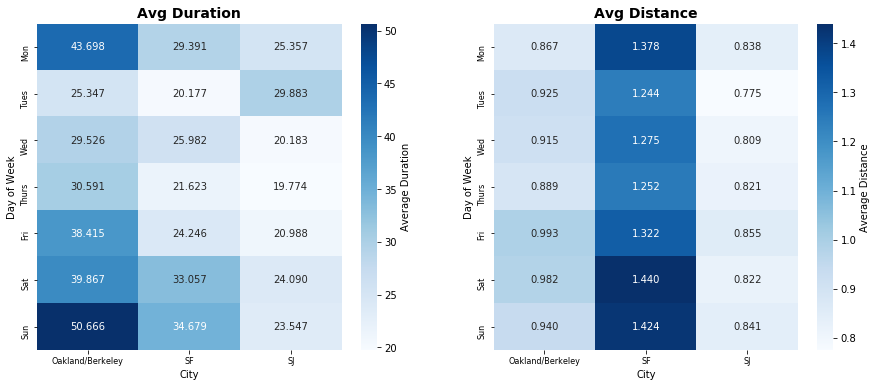

In [61]:
plt.figure(figsize = [15, 6]);

#Subplot for duration  
dur_means = baywheels.groupby(['day_of_week', 'start_city']).mean()['duration_min']
dur_means = dur_means.reset_index(name = 'avg_duration')
dur_means = dur_means.pivot(index = 'day_of_week', columns = 'start_city',
                            values = 'avg_duration')
plt.subplot(1, 2, 1);
sb.heatmap(dur_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'Average Duration'}, cmap = 'Blues');
plt.title("Avg Duration".title(),
               fontsize = 14, weight = "bold");
plt.xlabel('City');
plt.xticks(fontsize = 8); 
plt.ylabel('Day of Week');
plt.yticks(fontsize = 8); 

#Subplot for distance
dist_means = baywheels.groupby(['day_of_week', 'start_city']).mean()['distance']
dist_means = dist_means.reset_index(name = 'avg_distance')
dist_means = dist_means.pivot(index = 'day_of_week', columns = 'start_city',
                            values = 'avg_distance')
plt.subplot(1, 2, 2)
sb.heatmap(dist_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'Average Distance'}, cmap = 'Blues');
plt.title("Avg Distance".title(),
               fontsize = 14, weight = "bold");
plt.xlabel('City');
plt.xticks(fontsize = 8); 
plt.ylabel('Day of Week');
plt.yticks(fontsize = 8); 


This gives us a more direct comparison between the three different variables. We previously saw that rides from Oakland/Berkeley had the highest duration, but now we can see that, specifically, rides from Oakland/Berkeley on Sunday last the longest. Similarly, we can see that rides in San Francisco on on Saturday have the highest average distance, with San Francisco in general having longer distance rides. On the duration side we can see that rides may get a little longer during the weekend, but, as discussed earlier, there is not a very strong trend. 

Finally, I'll create a clustered bar chart to examine the relationships between rider type, starting city, and avg distance/duration. 

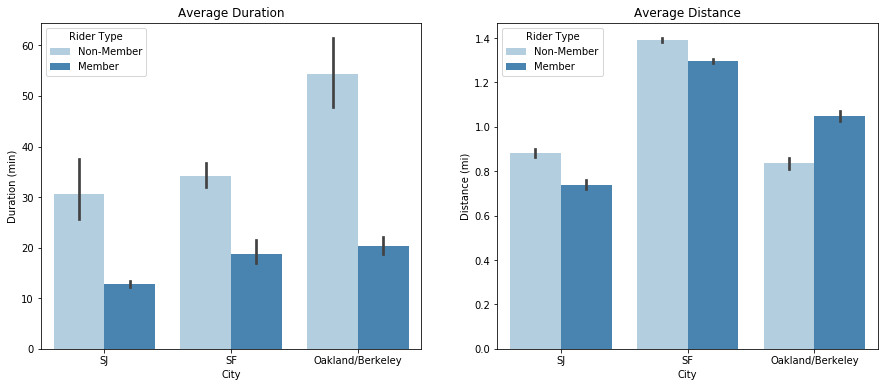

In [62]:
plt.figure(figsize = [15, 6]);

plt.subplot(1, 2, 1);
ax = sb.barplot(data = baywheels, x = 'start_city', y = 'duration_min', hue = 'member_casual', palette = 'Blues')
legend = ax.legend(loc = 2, title = 'Rider Type');
for t, l in zip(legend.texts,("Non-Member", "Member")):
    t.set_text(l)
plt.xlabel('City'); 
plt.ylabel('Duration (min)');
plt.title("Average Duration");

plt.subplot(1, 2, 2);
ax2 = sb.barplot(data = baywheels, x = 'start_city', y = 'distance', hue = 'member_casual', palette = 'Blues')
legend2 = ax2.legend(loc = 2, title = 'Rider Type');
for t, l in zip(legend2.texts,("Non-Member", "Member")):
    t.set_text(l)
plt.xlabel('City'); 
plt.ylabel('Distance (mi)');
plt.title("Average Distance");

From this, we can see again that most riders are non-members. Interestingly, non-members tend to take longer rides in all three cities. Average distance is also longer for non-members in San Jose and San Francisco, though the difference between members and non-members is less pronounced. 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

>This section provided some insight into the interactions between multiple variables. Though it is a little surprising that weekend rides were not significantly longer in distance or duration, we can still see that Oakland/Berkeley rides have higher average durations and San Francisco rides have higher average distances. Additionally, we can see that non-members generally have longer duration in all 3 cities, while distance is about the same between members and non-members across all 3 cities.  


<a id='conclusion'></a>
## Conclusions

In this project, I performed analysis on data from Lyft's Bay Wheels service, a bikesharing service based in the Bay Area. Some key insights include: 
* **Peak hours**: More rides were taken on weekends, with the peak of activity being on Memorial Day weekend. Peak hours during the day were around 12PM - 5PM. During the week, number of rides generally increases from 12PM to 5PM, and then tapers down. During the weekend, the peak occurs around 2-3PM. During off-hours, which can be loosely described as 12AM - 4AM and after 8PM, number of rides was about the same across all days of the week. 
* **Ride details**: Removing some outliers, it was found that the average trip lasts around 15-30 minutes and the average distance betwen start and end station is somewhere between 0.5 - 1.0 miles. 3 geographical clusters (corresponding to major cities) were identified: San Francisco, San Jose, and Oakland/Berkeley. Rides starting from Oakland/Berkeley tended to have higher average duration, while rides starting from San Francisco had the highest average distance. 
* **Rider information**: Most riders are non-members. Members are mostly from San Francisco, with approximately equal numbers of members and non-members in San Jose and Oakland/Berkeley. 